In [1]:
import numpy as np, matplotlib.pyplot as plt, pymust
import tqdm, tqdm.notebook
import os

In [2]:
class MyOptions(pymust.utils.Options):
    def copy(self):
        p = MyOptions()
        for k in self.keys():
            p[k] = self[k]
        return p

## Single scatterer

To understand the color and pulse wave Doppler, we will first use a simple 1D setting with a single framework, and a unique piezoelectrical element. Contrary to the previous cases, where the scatterers are static, here they will move with a constant velocity. Note that MUST is not able to simulate the frequency shift in Doppler, as the scatterers are assumed to be static within the simulation, however, the phase change due to the displacement towards and away from the transducer can be simulated.

To measure the speed of the scatterers, we will transmit several pulses, and examine how the recieved radio frequency has changed at every pulse. The frequency at which these scatterers are fired is called the pulse repetition frequency (PRF), and it is typically of the order of 1kHz. The PRF is limited by the maximum depth we want to image (we need to assure that all echoes have arrived, before emmting a second wave) The scatterer changes $\frac{\Delta z}{c}$, where $\Delta z = \frac{v}{PRF}$, which typically results in both the timing of the recieved pulse, as well as the phase shift between two consecutive . However, changes in the recieved time are usually too small to be accurately quantified, and changes in phase are more robust to measure.

#### A note on the derivation of the Doppler formula
Here we will derive the formula relating the phase shift and the velocity. Suppose two sequential acquisitions, which are $\frac{1}{PRF}$s appart and there is a single scatterer moving towards the probe with velocity $v$. We note the emmited signals as $e_0(t)$, $e_1(t)$, and the recieved signals are $r_0(t)$ and $r_1(t)$. Then, if we emmit a signal is $e_0(t)$ (with $t = 0$ being the time at which the emmision started), the recieved signal $r(t)$ will be a scaled (due to dispersion, and that only a small portion of the wave is backscattered). Then, $r_0(t) = k e(t - \Delta t)$, where $k$ is a scaling parameter that we will ignore for the analysis (since it mostly reflects the reflexive coefficient of the scatterer, and not its velocity), and $\Delta t = \frac{2x}{c}$ is the delay between emmision and reception at time $0$. If we wait for the second acquisition, then the scatterer has moved $\frac{v}{PRF}$  in the direction of the probe, and therefor it is closer and its $\Delta t' = \frac{2(x - \frac{v}{PRF})}{c}$ is smaller. Therefore, $r_1(t) = r_0(t - \frac{v}{PRF\cdot c})$.

Now, we will assume that the emitted signal is a pure sinusoid around the center frequency of the probe (in fact it will be similar to a temporally-boxed sinusoid, see exercise 1.2 from P1, the exercise with TXNow that emits several pulses in a row). Then $r_0(t) = sin(2 \pi f_c \cdot t)$, and $r_1(t) = sin(2\pi f_c \cdot (t - \frac{v}{PRF\cdot c}))$. We can simplify this further by saying that  $r_1(t) = sin(2\pi f_c t + \Delta_\theta)$ where the phase difference is expressed as $\Delta_\theta = \frac{4v\pi f_c}{c \cdot PRF}$. Notice that from signals and systems, you can compute the shift between two sinusoids using the convolution, and in practice it is implemented using the correlation of the consequtive IQ signals.

### Simulation with movement

In this session, we will use a class that simulates scatterers moving with constant velocity. Since you should already know how to call simus since P2, that part fo the code is already for you. The class definition involves defining the parameter, as well as the scatterers reflective coefficient, positions and velocities. Then, you can call simulate which requires specifying the number N of emitted pulses. Then, it will return a list of length N, each corresponding to the radiofrequencies obtained. The position of the scatterers is updated after each RF acquisition, in order to model its movement.

In [3]:
class SimulationWithMovement:
    """
    This class allows to do a simulation with scatterers moving with a certain velocity
    """
    def __init__(self, param, xScatterers, zScatterers, vXScatterers, vZScatterers, RCScatterers):
        self.param = param
        self.xScatterers_ = xScatterers.copy()
        self.zScatterers_ = zScatterers.copy()
        self.vXScatterers = vXScatterers.copy()
        self.vZScatterers = vZScatterers.copy()
        self.RCScatterers = RCScatterers.copy()
        self.reset()
        
    def simulate(self, nReps):
        assert self.param.PRF is not None, 'param has not the PRF set. You should set it manually before calling this function.'
            
        zScatterers = self.zScatterers.copy()
        xScatterers = self.xScatterers.copy()

        for i in range(nReps):
            txdelay = pymust.txdelay(0, 5e-2, self.param)
            RF_new, _ = pymust.simus(xScatterers, zScatterers, self.RCScatterers,  txdelay, self.param)
            xScatterers += self.vXScatterers /self.param.PRF
            zScatterers += self.vZScatterers /self.param.PRF
            if i ==0:
                RFs = np.zeros([RF_new.shape[0], RF_new.shape[1], nReps])

            RFs[:, :, i] = RF_new
        return RFs
    def reset(self):
        self.xScatterers = self.xScatterers_.copy()
        self.zScatterers = self.zScatterers_.copy()


In the first exercise, we will understand the  phase shift. Run the experiment of a single scatterer moving at  below.

***Exercise 1: Phase shift (Color Doppler - 10 pts)***
1. Observe phase delay in plot. Plot two consecutive recieve signals and compare them and compute their time difference.  Convert it to phase difference, assuming a sinusoid at the probe central frequency. [Note: Remember to correctly adjust the xlim, so you can correctly see the pulse, you can estimate the time difference by computing the distance between peaks].
1. Using the formula in the lab guide (or search within the pymust function iq2doppler), compute the velocity of the scatterer.
1. Search, and explain, with your own words, the relationship between autocorrelation and the phase delay. You can assume that the signals are pure sinusoids.
1. Compute the  theoretical frequency shift (i.e. real Doppler effect, not the phase shift) of an object moving at 1m/s, for a the central frequency of the probe. Compare this with the sampling frequency (4 times the central frequency), and comment on the approppriateness of ignoring it.
1. Change the xVelocity of the scatterer to 1e-1, and its zVelocity to 0. What do you observe now, and why?

In [4]:
param = pymust.getparam('P4-2v')
param.Nelements = 1
param.TXnow = 4

#Need to introduce a second scatterer so that the recieved signal has a constant length. 
#You can ignore it, since it has RC = 0
xScatterers= np.array([0, 0], dtype = float)
zScatterers = np.array([5e-2, 6e-2]) 
vZScatterers = np.array([-1e-1, 0])
vXScatterers = np.zeros(2, dtype = float)
RCScatterers = np.array([1, 0])

param.PRF = 1000 #PRF = 1lHz

nReps = 2

s = SimulationWithMovement(param, xScatterers, zScatterers, vXScatterers, vZScatterers, RCScatterers)
RFs = s.simulate(4)
ts = np.arange(RFs.shape[0])/param.fs
#RFS is a matrix of  RF (nTempSamples, nElements, nAcquisitions)

In this exercise, you need to remember that Doppler velocities are positive when moving TOWARDS the transducer, but physical (vZ) are positive when moving AWAY from the transducer.

***Exercise 2: Autocorrelation (20 pts)***
1. Test several different scatter velocities, between -0.5m/s to 0.5m/s. Create a table or a plot comparing: actual velocity with Doppler velocity, and the estimation error.
1. In the error column, there are  discontinuities. Why are they due? Use the approppriate formula to obtain the value of the first discontinuity, and compare it with the experimental.
1. Use TXNow = 10 instead, and repeat the first table. Comment on the results.
1. Change the PRF to 1.5 kHz, and to 0.75 KHz. Repeat the table/plot; and comment on the results. 

In [5]:
param.TXnow = 4

vZScatterers[0] =.01
s1 = SimulationWithMovement(param, xScatterers, zScatterers, vXScatterers, vZScatterers, RCScatterers)
s1.reset()

RFs = s1.simulate(nReps)
x = np.array([[0]])
z = np.array([[5e-2]])
IQs = np.stack([pymust.rf2iq(RFs[:,:,i], param.fs) for i in range(RFs.shape[-1])], axis = 2)
Mdas = pymust.dasmtx(IQs[:,:,0],x,z, param)  #MDAS using a single pixels
IQs_b = np.stack([ pymust.utils.applyDasMTX(Mdas, pymust.rf2iq(RFs[:,:,i], param.fs),(1,1) )for i in range(RFs.shape[-1])], axis = 2)


-0.009885593938549906

In [6]:
# Repeat this for several values of velocity, including 0. You can use linspace

## Part 2: Color Doppler images

In this exercise, you will see an example of using color Doppler

***Exercise 3: Rotating disk (10 pts)*** 
1. Generate a B-mode images of the disk, and also of the rotated one. Use a rotation large enough so that you can obseve a rotation  using the small disk with higher reflectivity as a reference.
1. Knowing the radius of the risk and the angular velocity, what is the maximum velocity that will be observed?
1. Run the code to visualise the color Doppler of the disk. Visualise the, and describe what you see. Why is the velocity in the center 0?
1. Increase the angular velocity to  5 Hz. What do you observe, and why?
1. You will see velocity in some pixels of the background, that should be static. Why do you think they are due (remember P3).
 

In [7]:
small_test = True # Turn it to true if your computer has problems computing
param = pymust.getparam('L11-5v')
param.TXnow = 10

nPoints = 200000 if not small_test else 20000
xs = np.random.rand(1,nPoints)*12e-2-6e-2
zs = np.random.rand(1,nPoints)*12e-2

centerDisk = 0.05
idx = np.hypot(xs,zs-centerDisk)<2e-2 # First disk
idx2 = np.hypot(xs,zs-.035)< 5e-3 # Second disk, smaller with high intensity

RC = np.random.rand(*xs.shape)  # reflection coefficients

# Add reflectiion to both spheres
RC[idx] += 1
RC[idx2] += 2


# Rotating disk velocity
rotation_frequency = .5
w = 2 * np.pi  * rotation_frequency#1 Hz = 2 pi rads
nreps = 5
param.PRP = 1e-3

In [8]:
def rotatePoints(x, y, x0, y0, theta):
    """
    Rotate points (x,y) around (x0,y0) by theta radians
    """
    x = x - x0
    y = y - y0
    x1 = x * np.cos(theta) - y * np.sin(theta) + x0
    y1 = x * np.sin(theta) + y * np.cos(theta) + y0
    return x1, y1

In [ ]:
options =  MyOptions()
options.ParPoolMode = 'thread'
options.ParPool_NumWorkers = 12
options.dBThresh = -6
options.ParPool = os.name == 'posix' # Only activate parallelism in mac / linux. Set this to True if you want to try it in windows

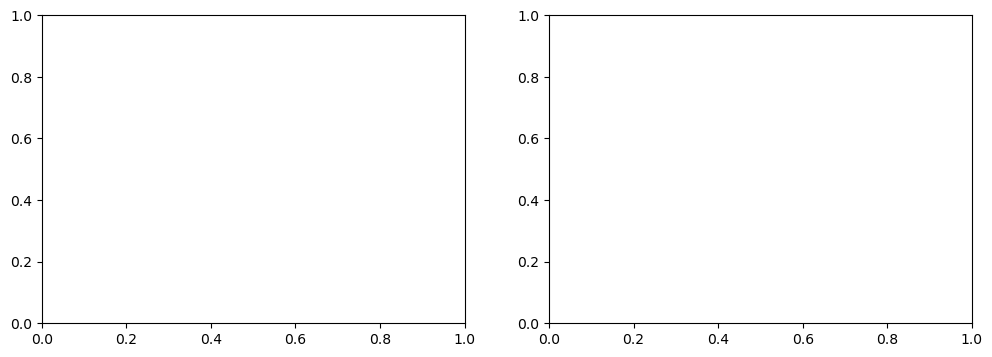

In [12]:
width = 5/180*np.pi; # width angle in rad
txdel = pymust.txdelay(param, 0 ,width) # in s
RF_ref, RF_spectrum = pymust.simus(xs,zs,RC,txdel,param, options) # Remove options if it does not work
rotationAngle = 0 #rotate 0 rad (absolute) ; you will need to modify this
xs[idx], zs[idx] = rotatePoints(xs[idx], zs[idx], 0, centerDisk,  rotationAngle) #Rotate the disk a certain amount, this should 
RF_rotated, RF_spectrum = pymust.simus(xs,zs,RC,txdel,param, options) # Remove options if it does not work

# TO COMPLETE BY THE STUDENTS: create the bmodes of the 
_, (f1, f2 ) = plt.subplots(ncols = 2, figsize = (12, 4))


In [9]:
for i in tqdm.notebook.tqdm(range(nreps)):
    xs[idx], zs[idx] = rotatePoints(xs[idx], zs[idx], 0, centerDisk,  w *  param.PRP)
    width = 5/180*np.pi; # width angle in rad
    txdel = pymust.txdelay(param, 0 ,width) # in s
    RF, RF_spectrum = pymust.simus(xs,zs,RC,txdel,param, options) # Remove options if it does not work
    if i ==0:
        IQ = np.zeros([RF.shape[0], RF.shape[1], nreps], dtype = np.complex128)
    IQ[:, :, i] = pymust.rf2iq(RF,param)

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
x,z = pymust.impolgrid(np.array([256, 256], dtype = np.int64),
                          10e-2, 
                          np.pi/2,
                          param)
Mdas = pymust.dasmtx(IQ[:,:,0],x,z,param)
IQb = np.zeros((x.shape[0], x.shape[1], nreps), dtype = np.complex128)
for i in tqdm.notebook.tqdm(range(nreps)):
    IQb[:, :, i] = (Mdas@IQ[:,:,i].flatten(order = 'F')).reshape(x.shape, order = 'F')
    
doppler_vel, doppler_var = pymust.iq2doppler(IQb,param)
VN = pymust.getNyquistVelocity(param)


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_30089/3878602826.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
/var/folders/s4/bzy_db252n15287qgjz2gfzh0000gn/T/ipykernel_30089/3878602826.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm = plt.pcolormesh(z, x , doppler_vel,edgecolors='face', cmap = pymust.getDopplerColorMap().cmap, vmin = -VN, vmax = VN)


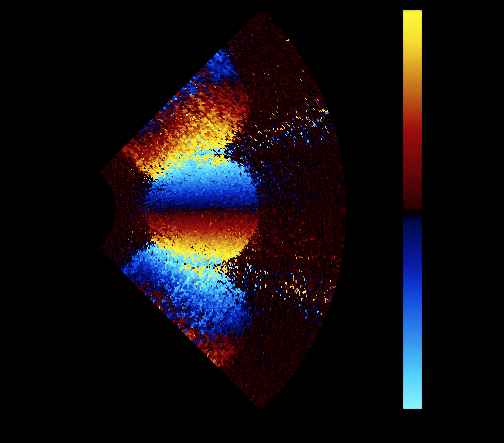

In [11]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.15,0.15,0.8,0.8])
fig.set_facecolor("black")
b = pymust.bmode(IQb[:,:,0])

plt.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
plt.axis('equal')

cm = plt.pcolormesh(z, x , doppler_vel,edgecolors='face', cmap = pymust.getDopplerColorMap().cmap, vmin = -VN, vmax = VN)
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
cbar = plt.colorbar(cm)
cbar.ax.set_ylabel('Velocity [m/s]')
ax = plt.gca()
ax.set_facecolor('black')